In [3]:
! pip install scikit-learn
import os
import sys
src_path = sys.path[0].replace("figures", "src")
# data_path = sys.path[0].replace("notebooks", "data")
if src_path not in sys.path:
    sys.path.append(src_path)

out_path = sys.path[0].replace("figures", "output")

import warnings
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from datetime import datetime, timedelta

from profile_extraction import ProfileExtraction
from data_loader import UCSD_dataloader
from utils.plot_utils import *
customize_plt() # customize plt configs, see plot_utils

exp_suffix = "May2023"
exp_folder = os.path.join(out_path, "experiments", exp_suffix)
if not os.path.exists(exp_folder):
    os.makedirs(exp_folder)
assert os.path.exists(exp_folder)

Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple
     ---------------------------------------- 8.3/8.3 MB 7.4 MB/s eta 0:00:00
     ---------------------------------------- 42.2/42.2 MB 3.5 MB/s eta 0:00:00
     -------------------------------------- 298.0/298.0 kB 3.1 MB/s eta 0:00:00


In [2]:
keys = ["load_pv", "load_bld", "bat_p", "ev_p", "p_grid"]
colors = {"load_pv":"rebeccapurple","load_bld":"chocolate","p_grid":"royalblue",
          "bat_p":"darkgreen","ev_p":"darkorange","cost":"firebrick",
        "gg":"seagreen", "gge":"seagreen", "pp":"royalblue", "nn":"plum",
          "msc":"firebrick", "tou":"sandybrown"}
names = {"load_pv":"PV","load_bld":"Building","p_grid":"Grid",
          "bat_p":"Battery","ev_p":"EV","cost":"Cost",
        "gg":"MPC-GG", "gge":"MPC-GGE", "pp":"MPC-PP", "nn":"MPC-NN",
          "msc":"MSC", "tou":"TOU"}

In [3]:
log_fn = "LOG-MPC_demo.xlsx"
log_df = pd.read_excel(os.path.join(exp_folder, log_fn), index_col=0)
exp_name = "MPC-demo"
log_df

,status,strategy,B_kWh,pred_model,deg_model_opt,deg_model,start,end,p_grid_max,price_dc,...,ev_I,load_bld,load_ev,load_tot,load_pv,grid_import,grid_export,import_cost,export_revenue,grid_max
id,,,,,,,,,,,,,,,,,,,,,
1,R,optimal,350,Simple,rainflow,DOD,10-1,10-8,1.5,0.6,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,R,optimal,350,GT,rainflow,DOD,10-1,10-8,1.5,0.6,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,R,optimal,350,Simple,unconscious,DOD,10-1,10-8,NaN,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,R,optimal,350,Simple,unconscious,DOD,10-1,10-8,1.5,0.6,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,D,optimal,350,Simple,rainflow,DOD,10-1,10-8,2.0,0.3,...,53.714286,1382.301607,428.661516,1810.963123,826.204336,1120.828123,143.813749,159.145758,27.465606,209.391314
6,D,optimal,350,GT,rainflow,DOD,10-1,10-8,2.0,0.3,...,53.714286,1382.301607,428.661516,1810.963123,826.204336,1103.408446,124.421394,155.169619,23.940823,150.609294
7,D,optimal,350,Simple,unconscious,DOD,10-1,10-8,2.0,0.3,...,53.714286,1382.301607,428.661516,1810.963123,826.204336,1194.871970,211.698508,164.017208,38.962828,196.241452


In [4]:
def get_trial_res(idx_mpc, idx_gt):
    mpc_fn = log_df.loc[idx_mpc, "save_fn"]
    gt_fn  = log_df.loc[idx_gt, "save_fn"]
    mpc_df = pd.read_excel(os.path.join(exp_folder, exp_name, mpc_fn), sheet_name=None, index_col=0)
    gt_df = pd.read_excel(os.path.join(exp_folder, exp_name, gt_fn), sheet_name="op_log", index_col=0)
    return mpc_df, gt_df

In [5]:
mpc_df, gt_df = get_trial_res(5,6)
mpc_df_UC, _ = get_trial_res(7, 6)

In [6]:
def draw_load_curve(mpc_df, gt_df, key, t0=datetime(2019,10,1,0,0), pred_t=0, gif=False, ax=None):

    ax = plt.gca() if ax is None else ax

    K, delta, exe_K = 96, 0.25, 4

    ts = pd.date_range(t0, t0+timedelta(hours=24), freq=f"{delta}H", inclusive="left")
    ts_exe = pd.date_range(t0, t0+timedelta(hours=24), freq=f"{delta*exe_K}H", inclusive="left")

    y_gt = gt_df.loc[ts, key].values
    if key in ["load_bld", "load_pv"]:
        y_mpc = mpc_df[f"pred_{key}"].loc[ts_exe, range(exe_K)].values.reshape(-1,)
    else:
        y_mpc = mpc_df["op_log"].loc[ts, key].values

    y_pred = mpc_df[f"pred_{key}"].loc[
        t0+timedelta(hours=pred_t), range(K - int(pred_t/delta))].values

    # if key == "load_pv":
    #     y_gt *= -1
    #     y_mpc *= -1
    #     y_pred *= -1

    x = np.arange(0, K*delta, delta)
    x_pred = np.arange(pred_t, K*delta, delta)

    c = colors[key]

    if gif:
        exe_steps = int(pred_t/delta)+1

        ax.fill_between(x[:exe_steps], y_gt[:exe_steps], y_mpc[:exe_steps], color=c, alpha=0.2, edgecolor="none", zorder=200)
        ax.fill_between(x_pred, y_gt[exe_steps-1:], y_pred, color=c, alpha=0.6, edgecolor="none", zorder=200)
        ax.plot(x[:exe_steps], y_mpc[:exe_steps], color=c)
        ax.plot(x_pred, y_pred, color=c, alpha=0.8, lw=1.5, ls="dashed", zorder=-100)
    else:
        ax.fill_between(x, y_gt, y_mpc, color=colors[key], edgecolor="none", alpha=0.3, zorder=-200)
        ax.plot(x, y_mpc, c=colors[key])
        ax.plot(x_pred, y_pred, color=colors[key], lw=1, ls="dashed", zorder=-100)

In [7]:
def text_with_ratio(text, x_ratio, y_ratio, ax, **kw):
    x_lo, x_hi = ax.get_xlim()
    y_lo, y_hi = ax.get_ylim()
    x = x_lo + x_ratio * (x_hi - x_lo)
    y = y_lo + y_ratio * (y_hi - y_lo)
    ax.text(x, y, text, **kw)

In [8]:
gif = False
pred_t = 0

def draw_load_breakdown(mpc_df, gt_df, gif=False, pred_t=0):
    fig, axs = plt.subplots(ncols=3, nrows=2, figsize=(12, 7), gridspec_kw={"width_ratios":[1,1,1.5]})
    gs = axs[0,2].get_gridspec()
    # remove the underlying axes
    for ax in axs[:, -1]:
        ax.remove()
    axbig = fig.add_subplot(gs[:, -1])

    for i in range(4):
        key = keys[i]
        ax = axs[i//2, i%2]
        draw_load_curve(mpc_df, gt_df, key, t0=datetime(2019,10,1,0,0), pred_t=pred_t, gif=gif, ax=ax)
        
        if i//2 == 0:
            ax.set_ylim(-5, 125)
        else:
            ax.set_ylim(-125, 155)
        ax.set_xticks(np.arange(0, 25, 6))
        if i//2 == 0:
            ax.set_xticklabels([])
            ax.tick_params(direction='in', axis="x")
        if i%2 == 1:
            ax.set_yticklabels([])
            ax.tick_params(direction='in', axis="y")
        
        text_with_ratio(names[key], 0.05, 0.88, ax, ha="left", va="bottom", fontsize=18, color=colors[key])
        
    ax = axbig
    key = "p_grid"
    draw_load_curve(mpc_df, gt_df, key, t0=datetime(2019,10,1,0,0), pred_t=pred_t, gif=gif, ax=ax)
    ax.set_xticks(np.arange(0, 25, 6))

    ax.yaxis.set_label_position("right")
    ax.yaxis.tick_right()
    ax.set_ylim(-105, 155)
    ax.set_xlim(-0.5, 24.5)

    text_with_ratio(names[key], 0.05, 0.93, ax, ha="left", va="bottom", fontsize=20, color=colors[key])

    # legend
    ax.fill_between([-100,-100], [0,0], [0,0], color="dimgrey", edgecolor="none", alpha=0.3, label="discr. w/ GT")
    ax.plot([-100,-100], [0,0], c="dimgrey", label="Operate")
    ax.plot([-100,-100], [0,0], c="dimgrey", lw=1, ls="dashed", zorder=-100, label="Schedule")

    ax.legend(loc="lower left", fontsize=16, labelcolor="dimgrey", handlelength=2)
    text_with_ratio("1 Oct, 2019", 0.7, 0.03, ax, ha="left", va="bottom", fontsize=14, color="dimgrey")

    if gif:
        text_with_ratio("{:02}:00".format(pred_t), 0.7, 0.10, ax, ha="left", va="bottom", fontsize=22, color="dimgrey")

    plt.tight_layout()

    return fig, axs

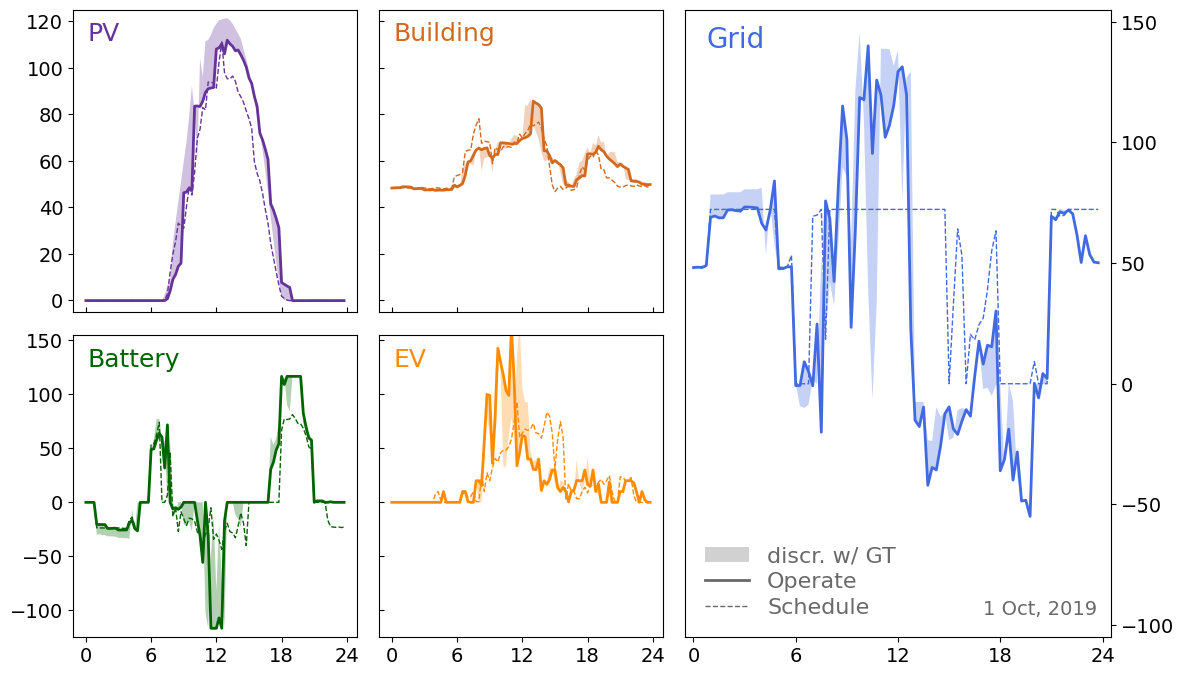

In [9]:
fig = draw_load_breakdown(mpc_df, gt_df, gif=False, pred_t=0)
# plt.savefig("214-fig3-MPC_demo.png", dpi=300, facecolor="w", bbox_inches="tight")

In [10]:
gif_folder = os.path.join(sys.path[0], "MPC_demo_gif")

C:\Users\Lunlo\AppData\Local\Temp\ipykernel_5000\4212030793.py:5: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, axs = plt.subplots(ncols=3, nrows=2, figsize=(12, 7), gridspec_kw={"width_ratios":[1,1,1.5]})


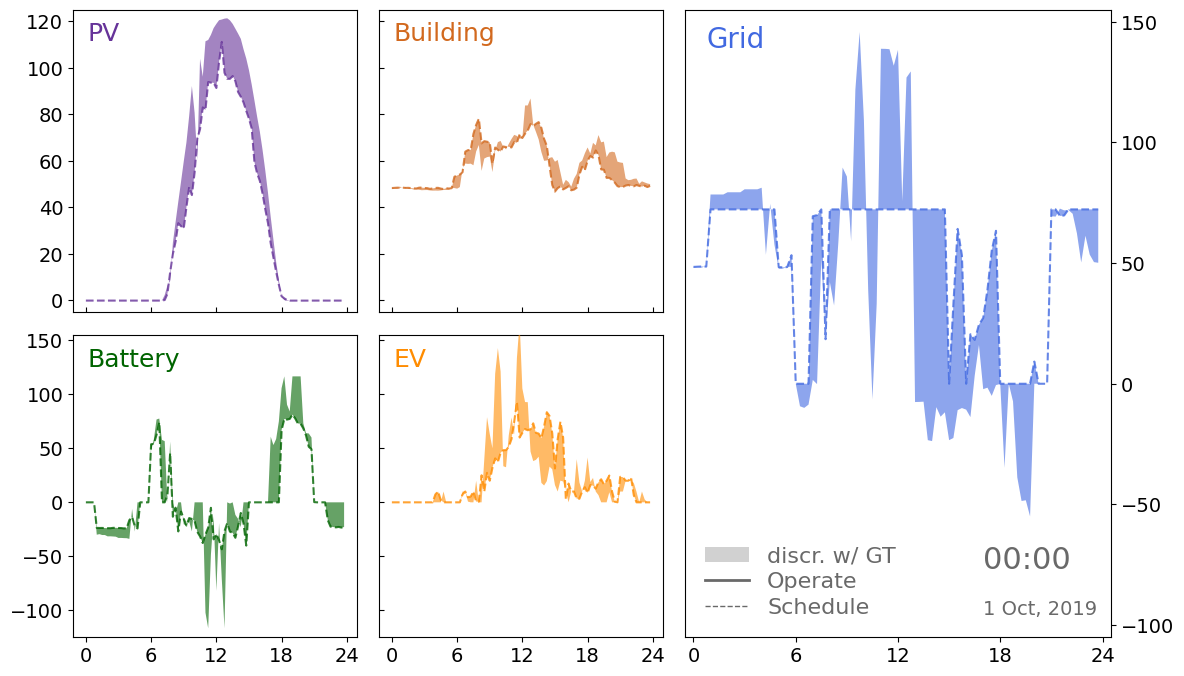

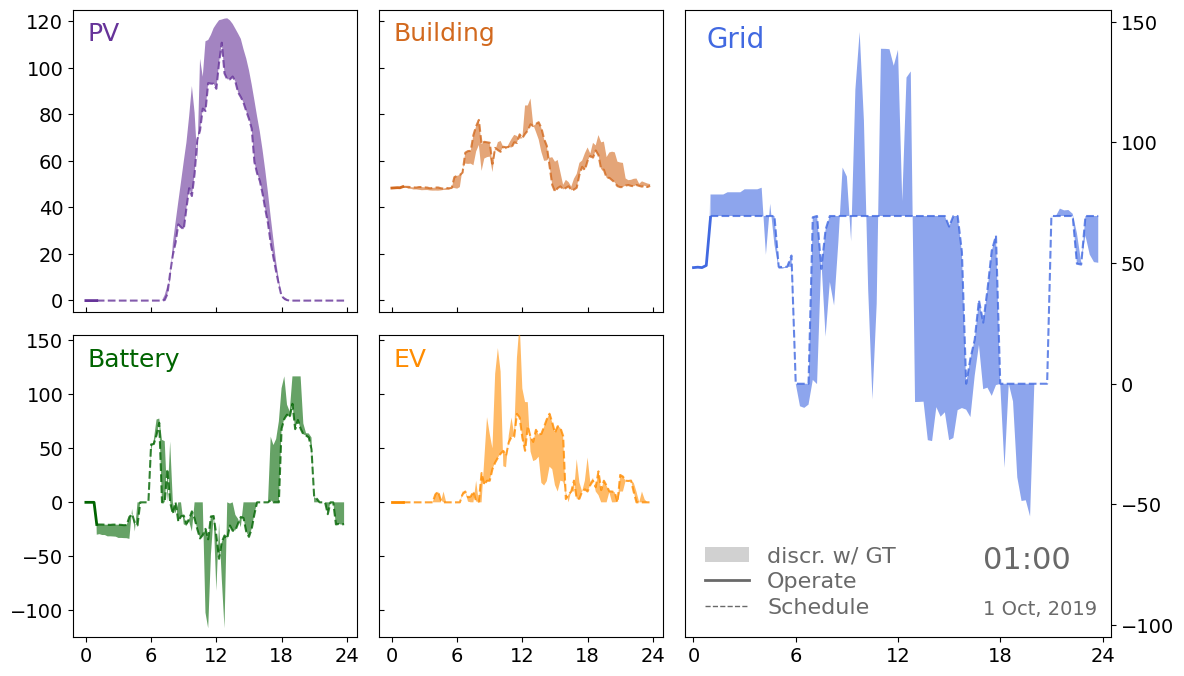

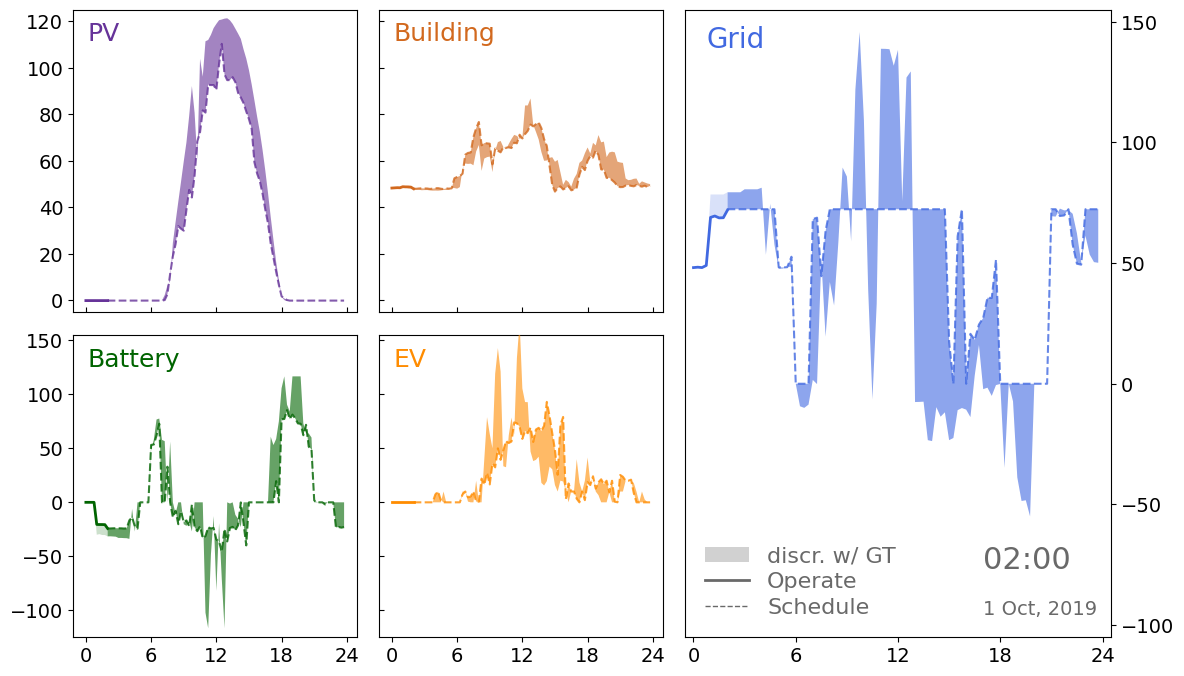

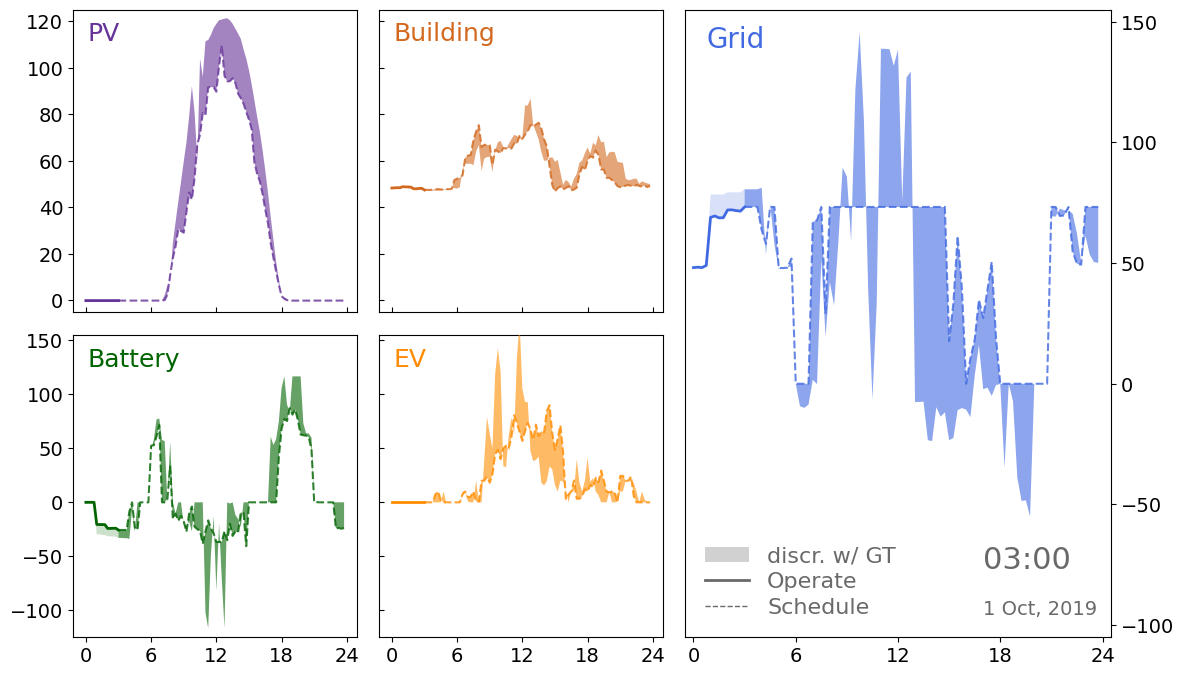

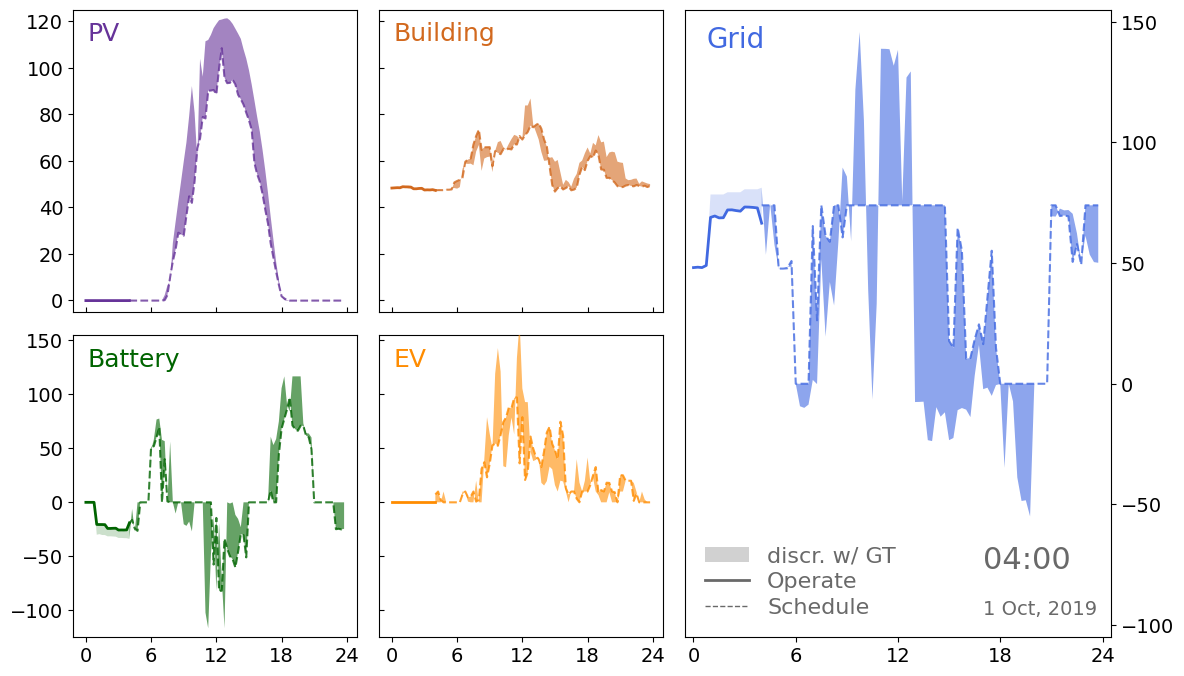

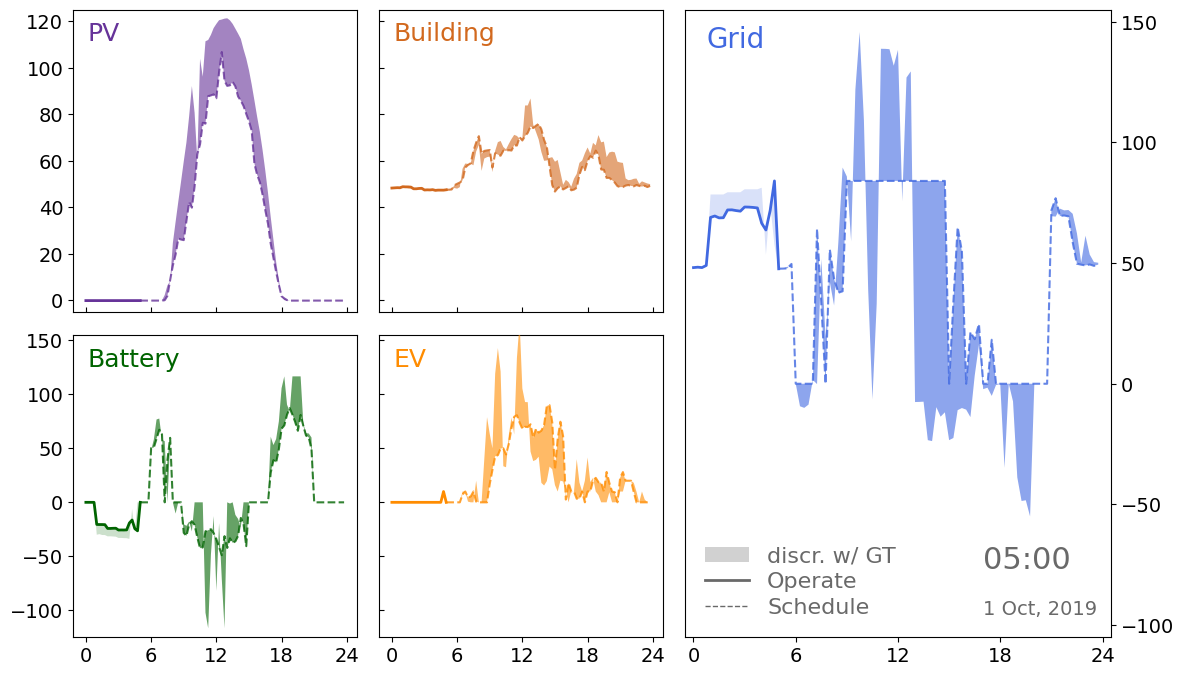

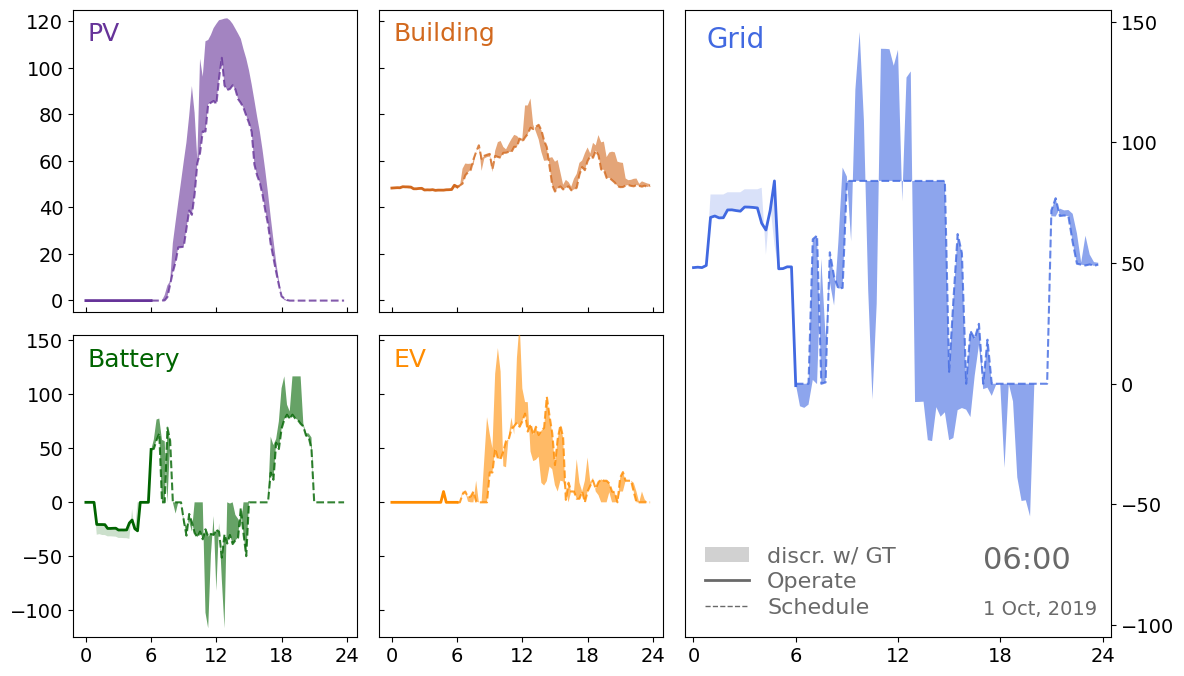

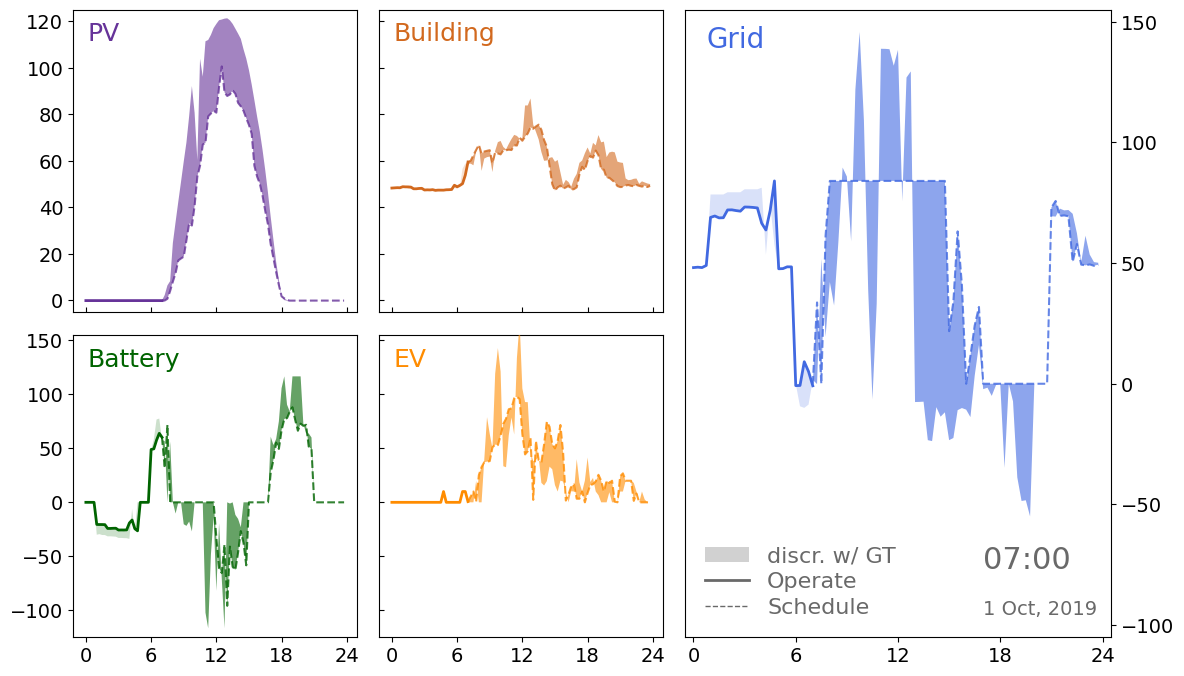

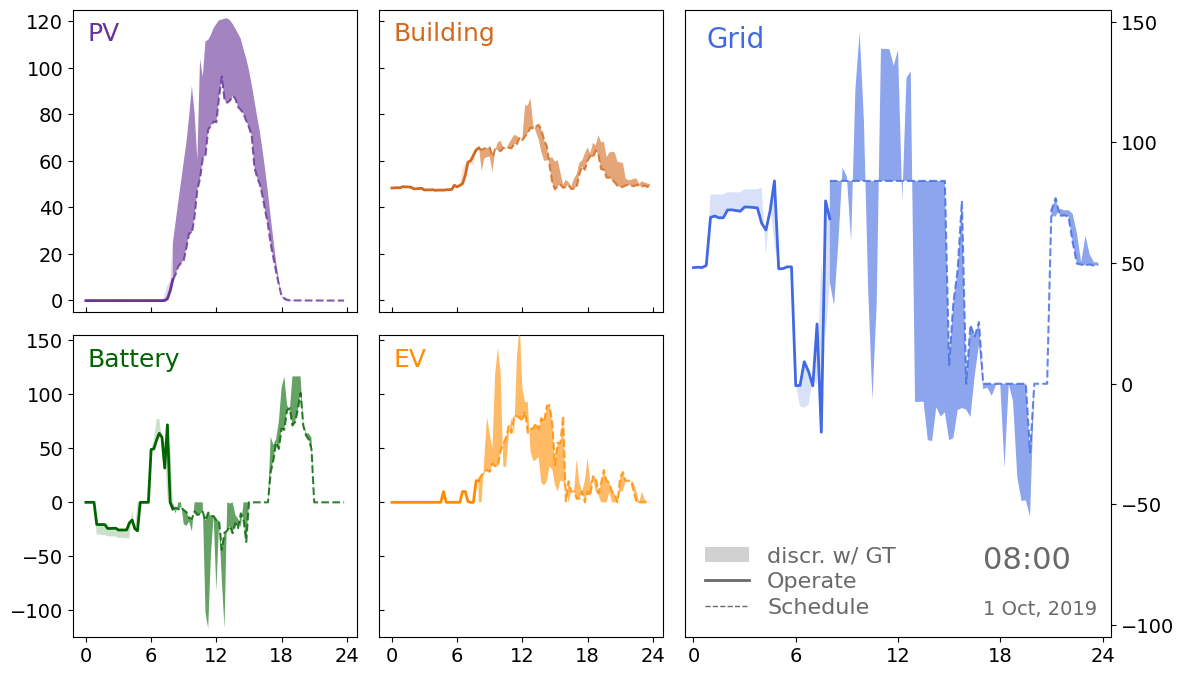

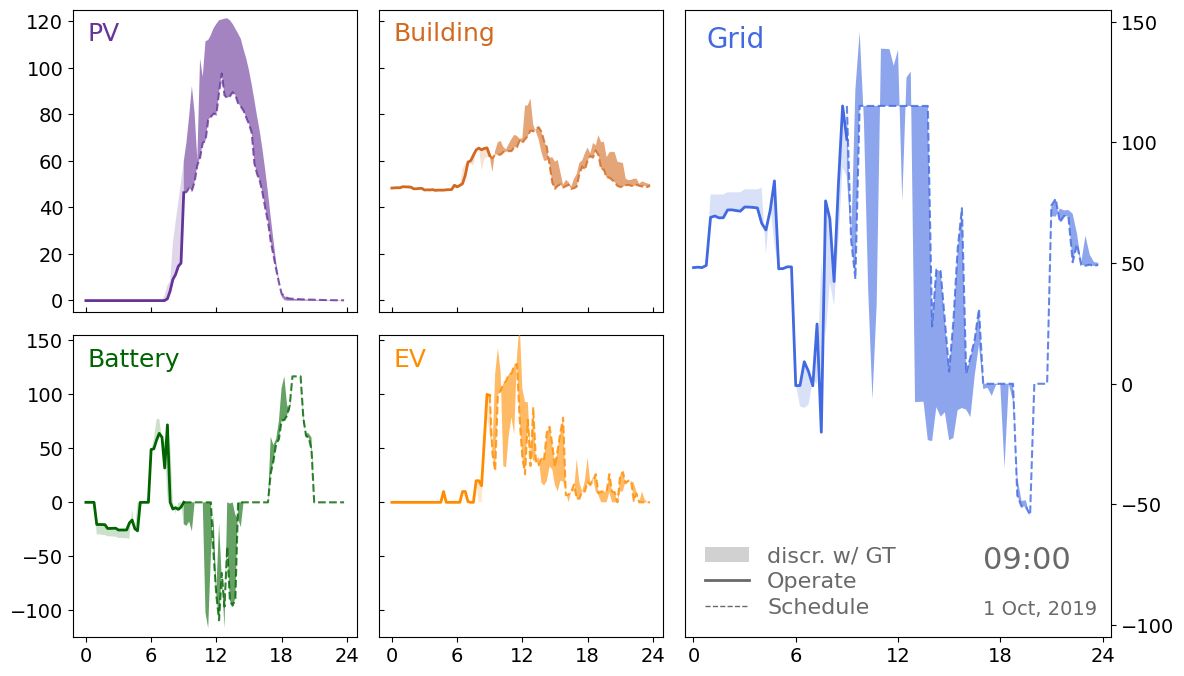

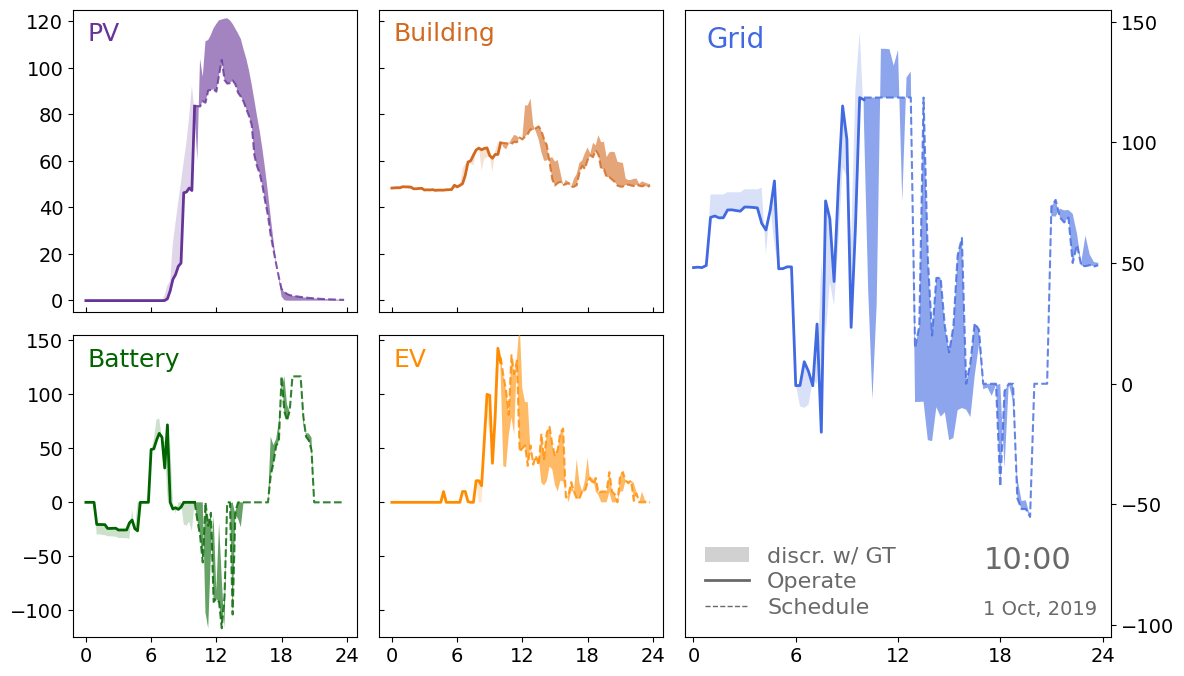

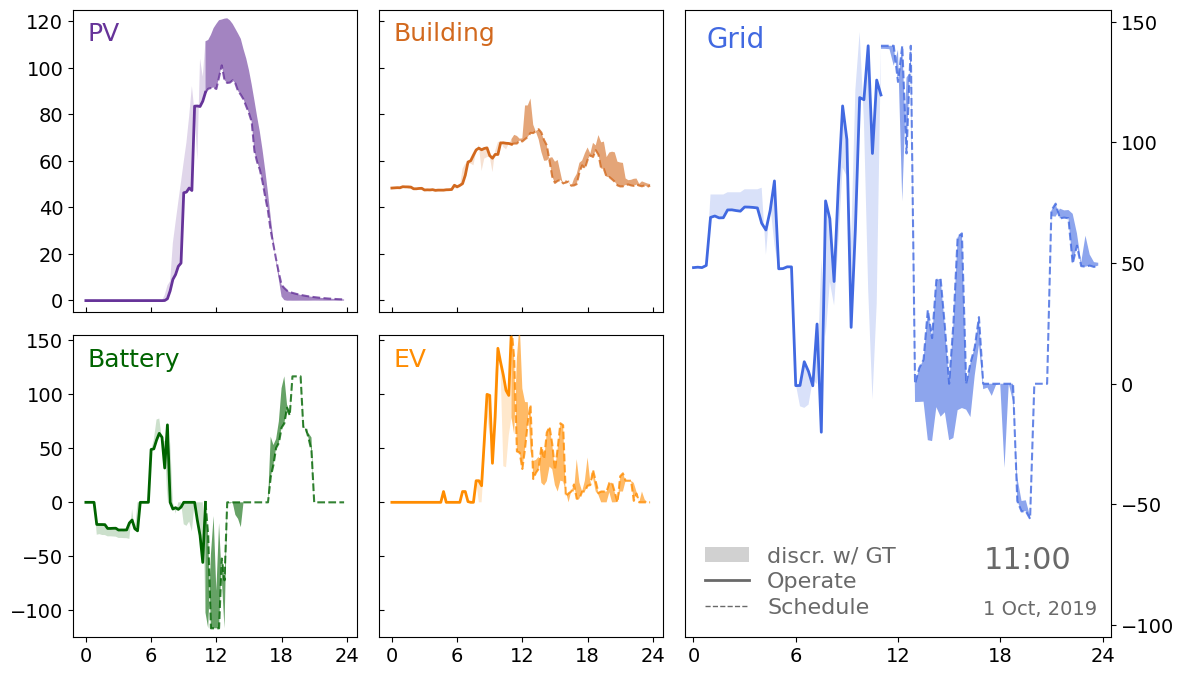

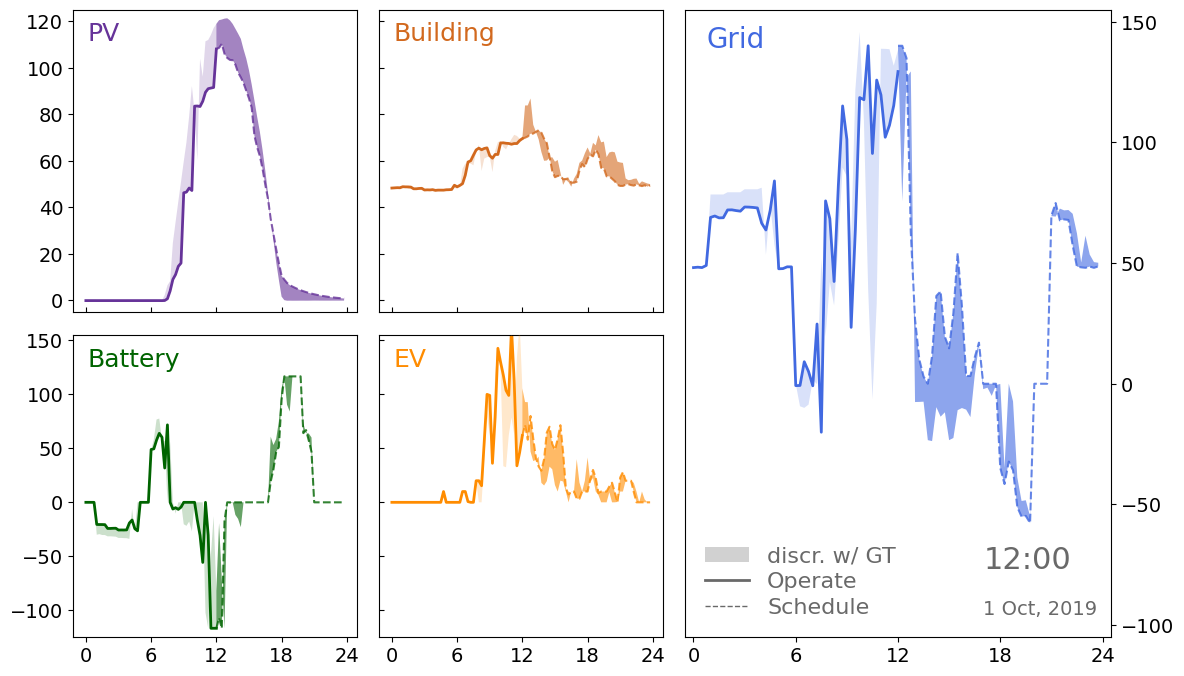

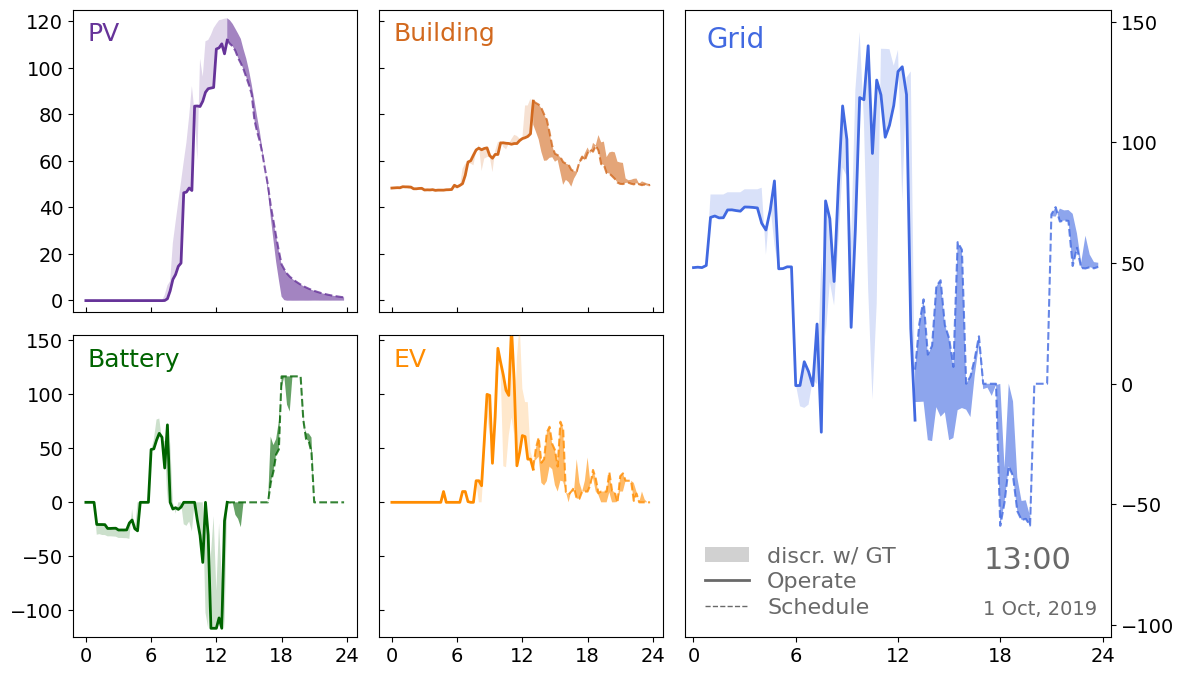

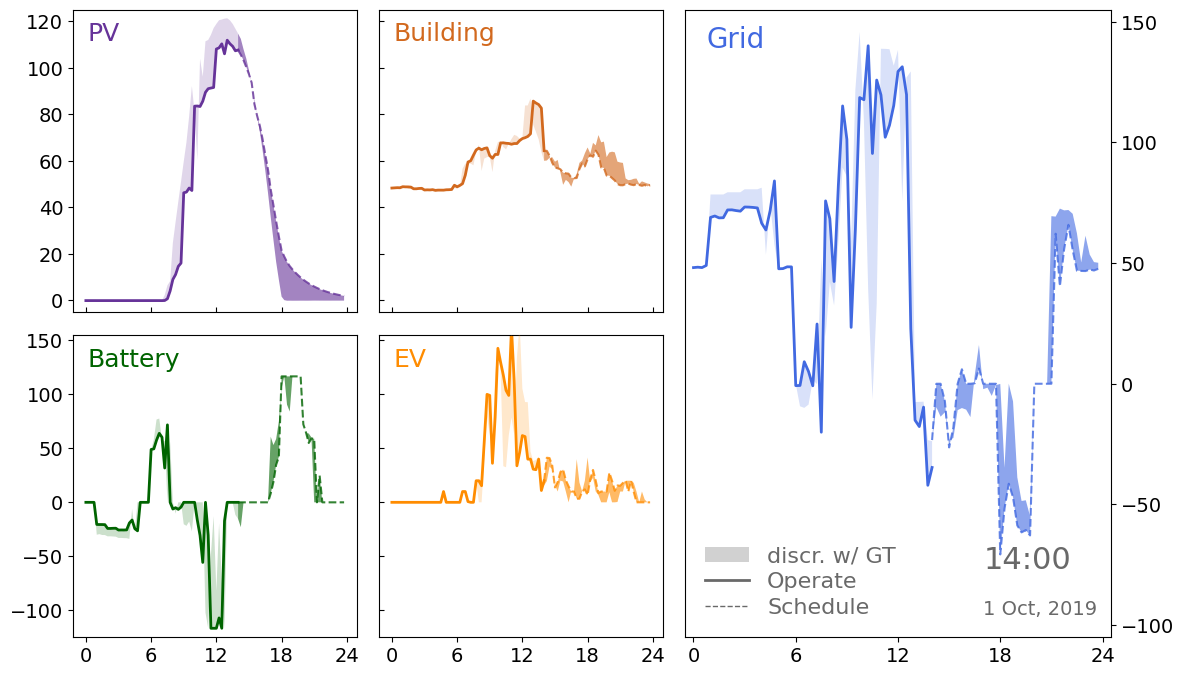

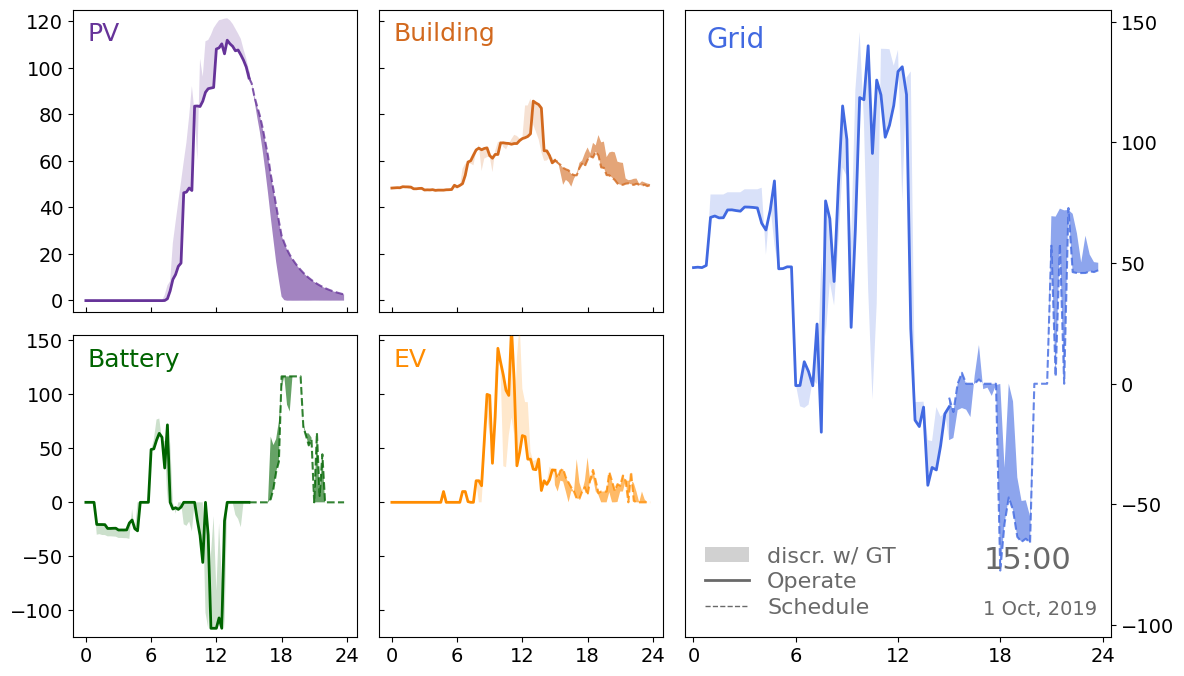

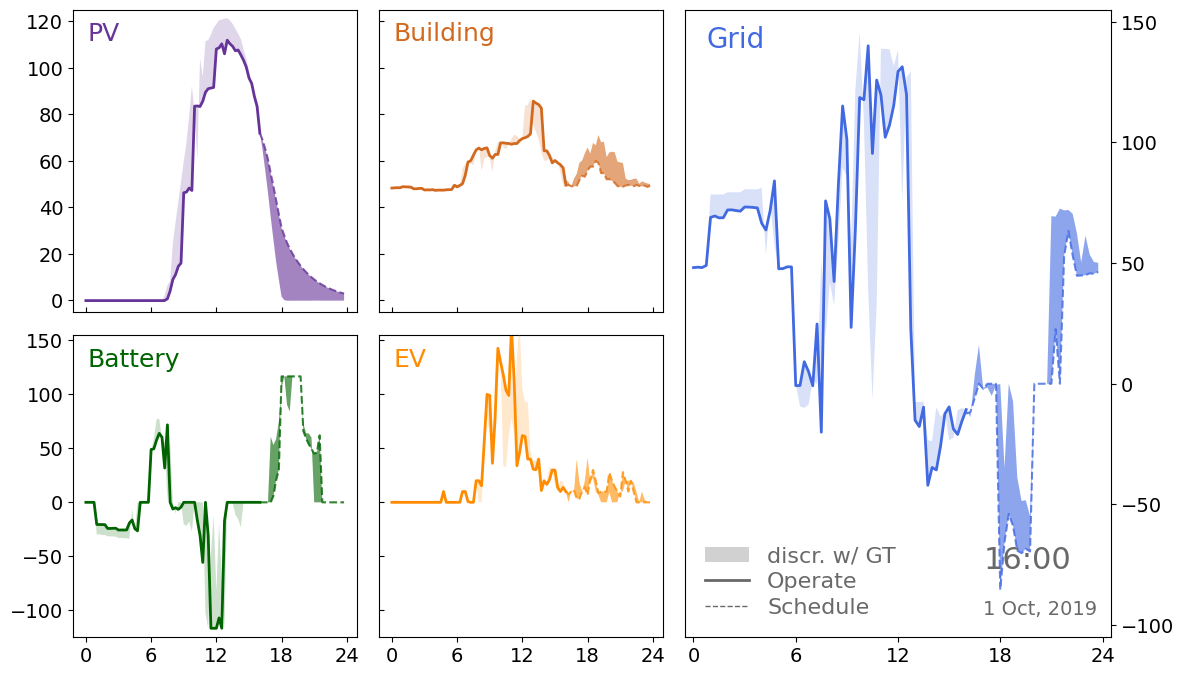

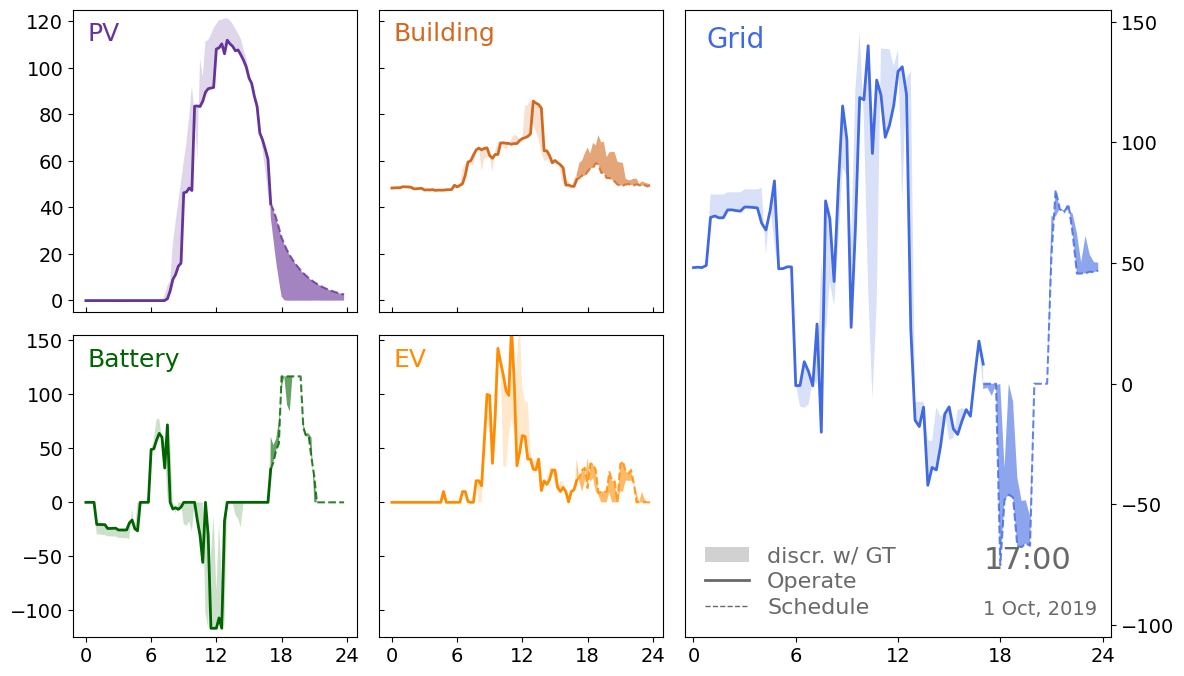

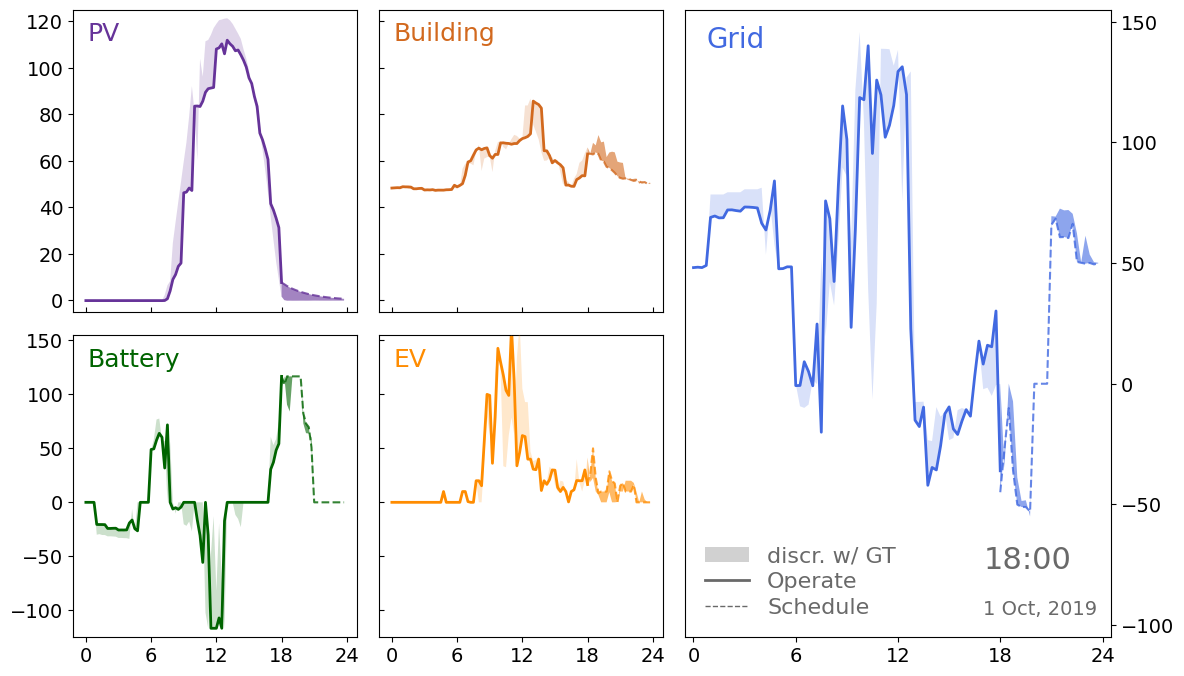

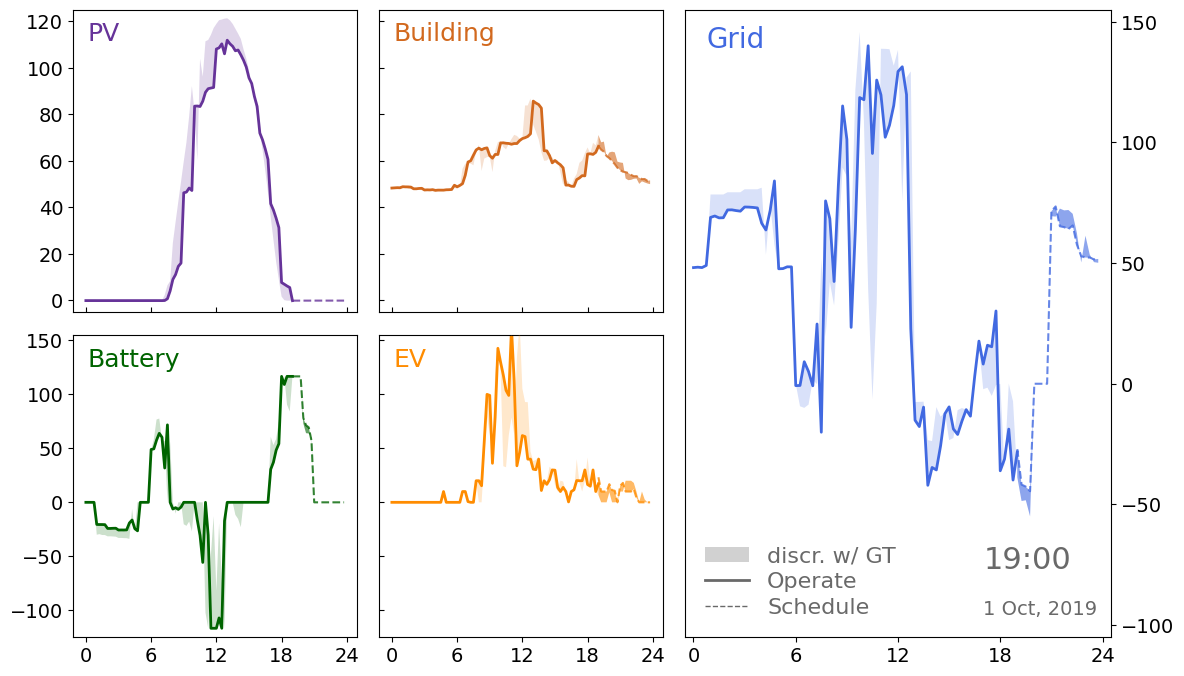

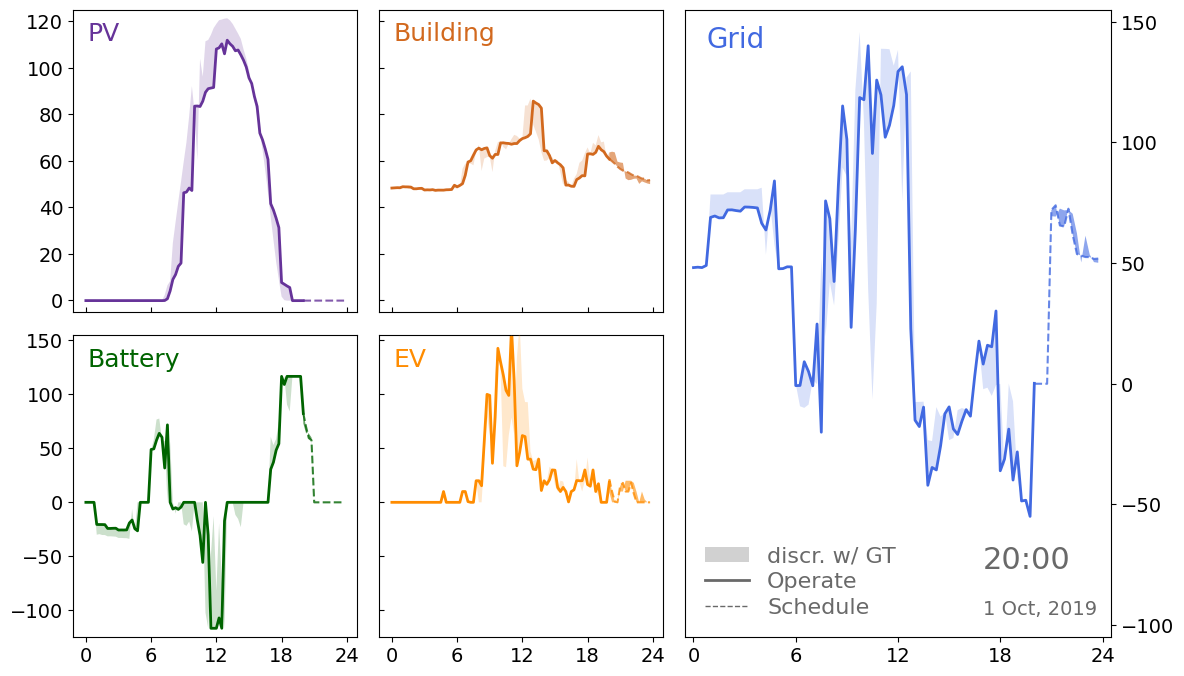

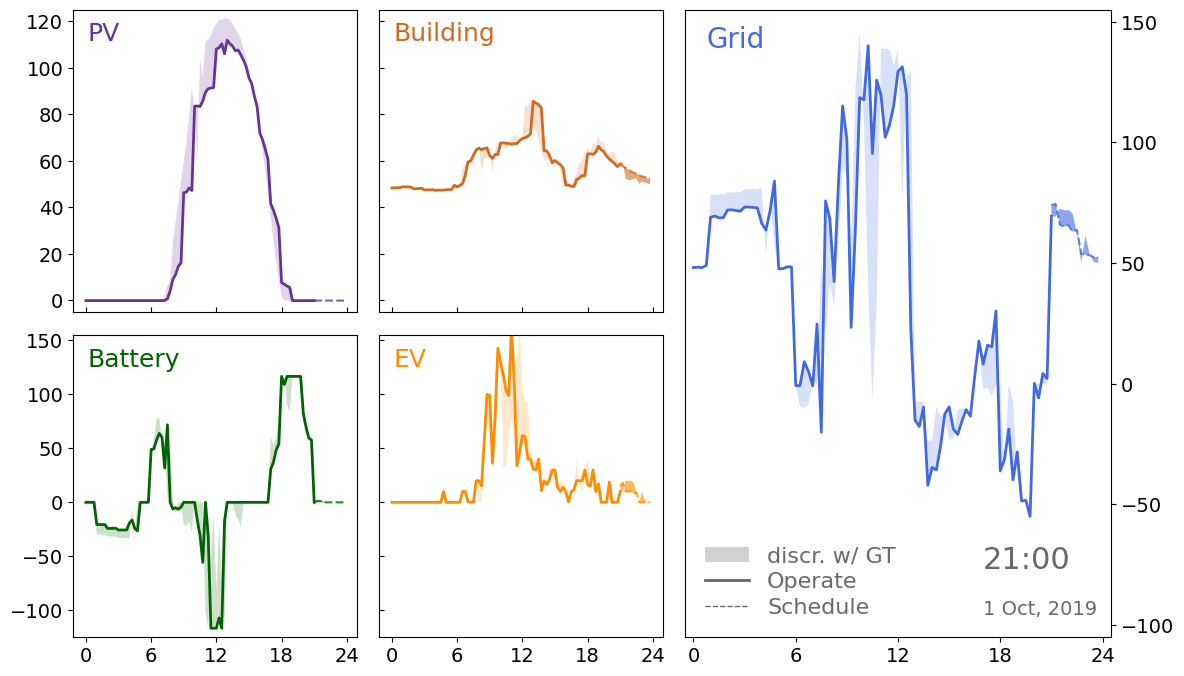

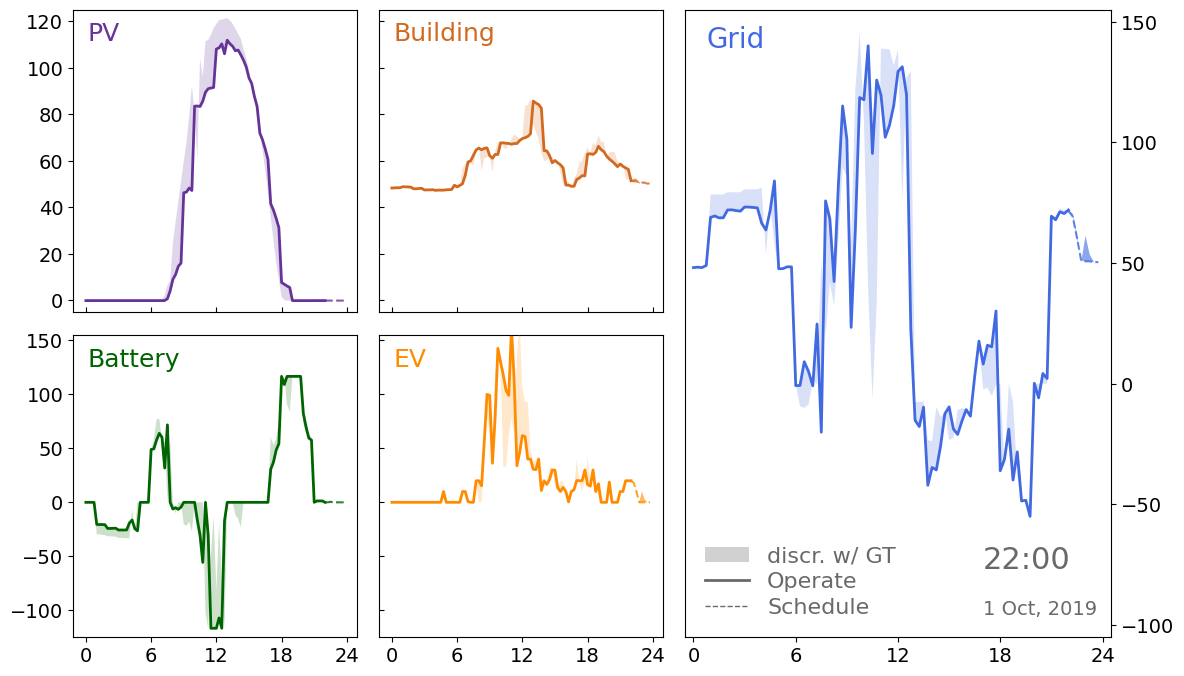

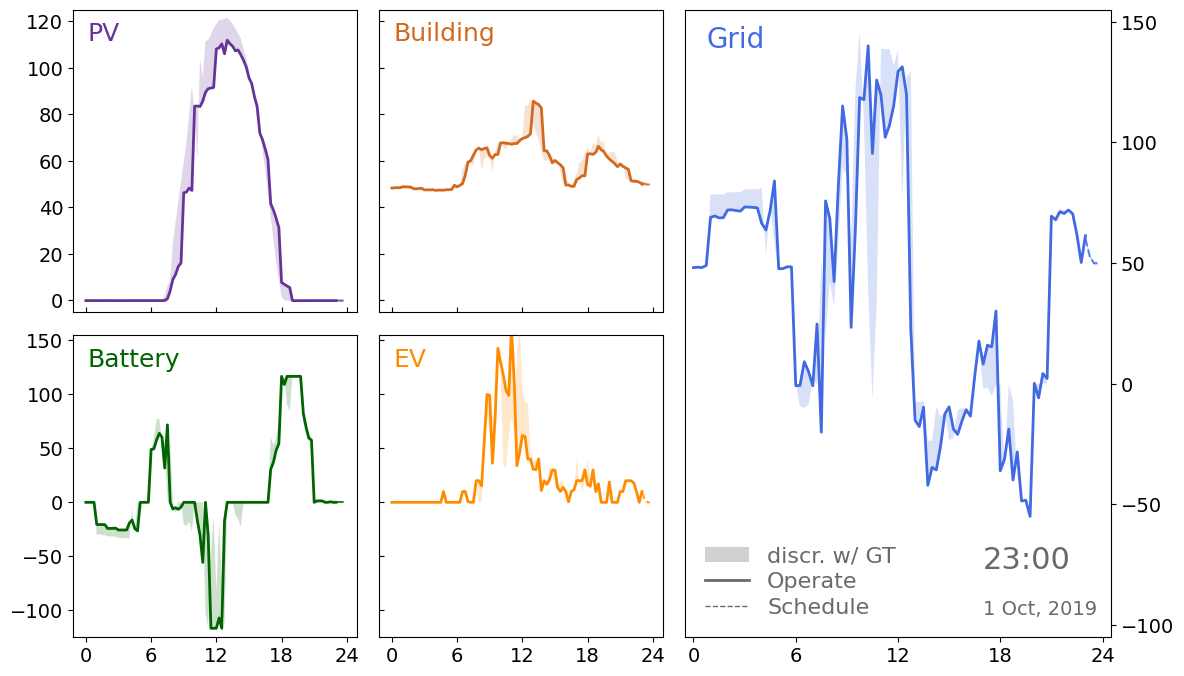

In [11]:
for t in range(24):
    fig = draw_load_breakdown(mpc_df, gt_df, gif=True, pred_t=t)
    save_fn = os.path.join(gif_folder, f"214-fig3-MPC_demo_gif-{t}.png")
    plt.savefig(save_fn, dpi=120, facecolor="w", bbox_inches="tight")

In [12]:
#! pip install imageio
import imageio

frames=[]
for filename in [os.path.join(gif_folder, f"214-fig3-MPC_demo_gif-{t}.png")
                     for t in range(24)]:
    image = imageio.imread(filename)
    frames.append(image)
gif_fn = "214-MPC_demo-gif-rainflow.gif"
imageio.mimsave(gif_fn, frames, format='GIF', duration=0.3)

C:\Users\Lunlo\AppData\Local\Temp\ipykernel_5000\3425645876.py:7: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


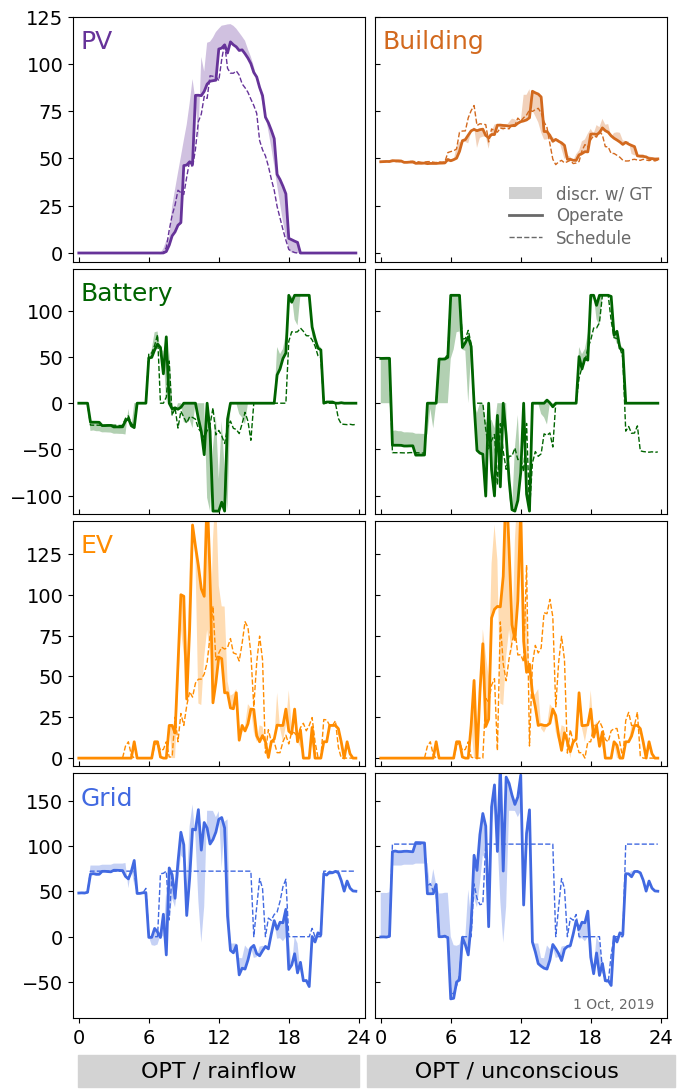

In [14]:
gif = False
pred_t = 0


y_lims = {
    "bat_p": (-120,145),
    "ev_p": (-5, 145),
    "p_grid": (-90, 180),
}

fig, axs = plt.subplots(ncols=2, nrows=4, figsize=(7, 11))
for i in range(2):
    key = keys[i]
    ax = axs[0, i]
    draw_load_curve(mpc_df, gt_df, key, t0=datetime(2019,10,1,0,0), pred_t=pred_t, gif=gif, ax=ax)
    ax.set_ylim(-5, 125)
    text_with_ratio(names[key], 0.05, 0.85, ax, ha="left", va="bottom", fontsize=18, color=colors[key])


for i in range(6):
    ax = axs[i//2+1, i%2]
    df = mpc_df if i%2 == 0 else mpc_df_UC
    key = keys[i//2+2]
    draw_load_curve(df, gt_df, key, t0=datetime(2019,10,1,0,0), pred_t=pred_t, gif=gif, ax=ax)
    y_lo, y_hi = y_lims[key]
    ax.set_ylim(y_lo, y_hi)

    if i%2 == 0:
        text_with_ratio(names[key], 0.05, 0.85, ax, ha="left", va="bottom", fontsize=18, color=colors[key])


for i in range(8):
    ax = axs[i//2, i%2]
    if i//2 < 3:
        ax.set_xticklabels([])
        ax.tick_params(direction='in', axis="x")
    
    ax.set_xlim(-0.5, 24.5)
    ax.set_xticks(np.arange(0, 25, 6))

    if i%2 == 1:
        ax.set_yticklabels([])
        ax.tick_params(direction='in', axis="y")


for i in range(2):
    ax = axs[3, i]
    xlabel = "OPT / rainflow" if i == 0 else "OPT / unconscious"
    ax.set_xlabel("{:^30}".format(xlabel), labelpad=10, backgroundcolor="lightgrey")

# legend
ax = axs[0,1]
ax.fill_between([-100,-100], [0,0], [0,0], color="dimgrey", edgecolor="none", alpha=0.3, label="discr. w/ GT")
ax.plot([-100,-100], [0,0], c="dimgrey", label="Operate")
ax.plot([-100,-100], [0,0], c="dimgrey", lw=1, ls="dashed", zorder=-100, label="Schedule")

ax.legend(loc="lower right", labelcolor="dimgrey", handlelength=2)

ax = axs[3,1]
text_with_ratio("1 Oct, 2019", 0.68, 0.03, ax, ha="left", va="bottom", fontsize=10, color="dimgrey")

plt.tight_layout(w_pad=0.1, h_pad=0.1)
plt.savefig("214-fig3-MPC_demo.eps")
# plt.savefig("214-fig3-MPC_RF-UC.png", dpi=300, facecolor="w", bbox_inches="tight")